In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from sklearn.model_selection import train_test_split

random_seed = 42
torch.manual_seed(random_seed)

In [3]:
import torchvision
from torchinfo import summary

# Download pretrained ViT weights and model
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
vit_base_12 = torchvision.models.vit_b_16(weights=vit_weights)

# Print a summary
summary(model=vit_base_12, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 1000]           768                  True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              True
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 197, 76

In [4]:
vit_transforms = vit_weights.transforms()

data_dir = '../EuroSAT/2750'
eurosat_dataset = datasets.ImageFolder(data_dir, transform=vit_transforms)
eurosat_dataset
# Split the data into train and test sets while preserving the original split

Dataset ImageFolder
    Number of datapoints: 27000
    Root location: ../EuroSAT/2750
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )

In [5]:
from torch.utils.data import DataLoader, random_split

#split into 80,10,10
total_size = len(eurosat_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(
    eurosat_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42)
)

# Create DataLoader instances for train, validation, and test sets
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size*2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size*2, shuffle=False)

In [7]:
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


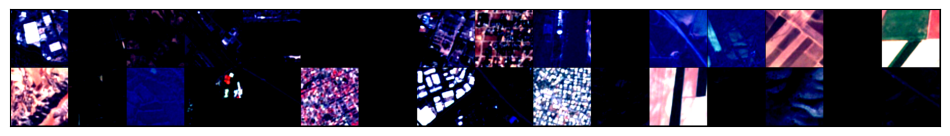

In [8]:
show_batch(train_loader)

In [9]:
# Define the ResNet-18 model
class EuroSAT_ViTBase12(nn.Module):
    def __init__(self):
        super(EuroSAT_ViTBase12, self).__init__()
        self.eurosat = vit_base_12  # Initialize ResNet-18 without pretrained weights
        self.eurosat.heads = nn.Linear(768, 10)  # Change output layer to have 10 classes

    def forward(self, x):
        return self.eurosat(x)

model = EuroSAT_ViTBase12()

# Loss and optimizer

In [10]:
model

EuroSAT_ViTBase12(
  (eurosat): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
model = model.to(device)

In [13]:
# Hyperparameters
num_epochs = 10
learning_rate = 1e-3

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
#Fine-Tune on all the layers..

for name, param in model.named_parameters():
    print(f"Parameter name: {name}, Size: {param.size()}")
    print(param.requires_grad)

Parameter name: eurosat.class_token, Size: torch.Size([1, 1, 768])
True
Parameter name: eurosat.conv_proj.weight, Size: torch.Size([768, 3, 16, 16])
True
Parameter name: eurosat.conv_proj.bias, Size: torch.Size([768])
True
Parameter name: eurosat.encoder.pos_embedding, Size: torch.Size([1, 197, 768])
True
Parameter name: eurosat.encoder.layers.encoder_layer_0.ln_1.weight, Size: torch.Size([768])
True
Parameter name: eurosat.encoder.layers.encoder_layer_0.ln_1.bias, Size: torch.Size([768])
True
Parameter name: eurosat.encoder.layers.encoder_layer_0.self_attention.in_proj_weight, Size: torch.Size([2304, 768])
True
Parameter name: eurosat.encoder.layers.encoder_layer_0.self_attention.in_proj_bias, Size: torch.Size([2304])
True
Parameter name: eurosat.encoder.layers.encoder_layer_0.self_attention.out_proj.weight, Size: torch.Size([768, 768])
True
Parameter name: eurosat.encoder.layers.encoder_layer_0.self_attention.out_proj.bias, Size: torch.Size([768])
True
Parameter name: eurosat.encoder

In [16]:
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        # Move data to GPU
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # if (i+1) % 10 == 0:
        #     print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Average Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.2f}%')

    #Validation stage
    model.eval()
    with torch.no_grad():
        val_loss=0
        val_correct = 0
        val_total = 0

        for i, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
                    
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_avg_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Average Loss: {val_avg_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
    
print('Training finished.')

Epoch [1/10], Train Average Loss: 1.2718, Train Accuracy: 52.47%
Epoch [1/10], Validation Average Loss: 0.9303, Validation Accuracy: 64.30%
Epoch [2/10], Train Average Loss: 0.6547, Train Accuracy: 76.96%
Epoch [2/10], Validation Average Loss: 0.5444, Validation Accuracy: 80.59%
Epoch [3/10], Train Average Loss: 0.4948, Train Accuracy: 82.86%
Epoch [3/10], Validation Average Loss: 0.4465, Validation Accuracy: 84.63%
Epoch [4/10], Train Average Loss: 0.4089, Train Accuracy: 85.72%
Epoch [4/10], Validation Average Loss: 0.3940, Validation Accuracy: 86.85%
Epoch [5/10], Train Average Loss: 0.3680, Train Accuracy: 87.51%
Epoch [5/10], Validation Average Loss: 0.3912, Validation Accuracy: 86.93%
Epoch [6/10], Train Average Loss: 0.3281, Train Accuracy: 88.61%
Epoch [6/10], Validation Average Loss: 0.3847, Validation Accuracy: 88.00%
Epoch [7/10], Train Average Loss: 0.3044, Train Accuracy: 89.46%
Epoch [7/10], Validation Average Loss: 0.2765, Validation Accuracy: 91.70%
Epoch [8/10], Train 

In [17]:
correct_test = 0
total_test = 0
test_loss = 0.0
with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

avg_loss_test = test_loss / len(test_loader)
accuracy_test = 100 * correct_test / total_test

In [18]:
print("Test accuracy: ",accuracy_test,"%", " Test Loss: ",avg_loss_test)

Test accuracy:  90.74074074074075 %  Test Loss:  0.26698630857606265


In [19]:
torch.save(model.state_dict(), 'eurosat-vit-base12-full-fine-tune.pth')